In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
#class contains news information
class NewsInfomation:
    title=descripton=""

In [3]:
#class that is for general functions
import re

class Utils:
    
    def get_stock_symbols(self,news_list):

        stock_symbols = []

        for news in news_list:
            #fetched symbol from title
            symbol = self.find_symbol(news.title)
            if(symbol is not None and symbol not in stock_symbols):
                stock_symbols.append(symbol)
             
            #fetched symbol from descriptio
            symbol = self.find_symbol(news.description)
            if(symbol is not None and symbol not in stock_symbols):
                stock_symbols.append(symbol)

        return stock_symbols
                        
    
    def find_symbol(self, text):
        regex_output = re.findall(r'\([A-Z]*:\s*[A-Z]*\)', text)
        if(len(regex_output)>0):
            exchange_stock_names = regex_output[0].replace("(","").replace(")","").split(":")
            print(exchange_stock_names)
            if(len(exchange_stock_names)>1):
                return exchange_stock_names[1].strip()

In [4]:
#class is resposible for html parsing
from bs4 import BeautifulSoup
import requests


class NewsParser:
        


    def get_news(self,url):
    
        response = requests.get(url)
        print(response)
        
        soup = BeautifulSoup(response.text, "html.parser")
        news_html_list = soup.find_all(class_="newsreleaseconsolidatelink display-outline")
                
        news_list = []
        count= 1
        for rows in news_html_list:
            
            news = NewsInfomation()
            
            #get description from node
            description = self.get_description(rows)
            if(description is not None):
                news.description =  description.get_text()

            #get title from node        
            title_with_time = self.get_title_from_root(rows)
            if(title_with_time is not None):
                news.title = title_with_time.get_text()
                
                if(title_with_time.small is not None):
                    time = title_with_time.small.get_text()
                    
                #remove time from title strings    
                if(news.title.strip() != "" and time.strip() != ""):
                    news.title = news.title.replace(time, '') 
  
            news_list.append(news)
            count += 1
        return news_list
    
    def get_title_from_root(self,news_root):
        
        title = None
        
        if(news_root.find(class_="col-sm-8 col-lg-9 pull-left card")is not None):
            title= news_root.find(class_="col-sm-8 col-lg-9 pull-left card").h3     
            
        elif(news_root.find(class_="no-top-margin remove-outline")is not None):
            title= news_root.find(class_="no-top-margin remove-outline")     
        
        return title

    
    def get_description(self,news_root):
        
        description = None
    
        result = news_root.find_all(lambda tag: tag.name == 'p' and 
                                  tag.get('class') == ['remove-outline'])        
        if(len(result)>0):
            description = result[0]

        return description

In [5]:
# this class select the first 4 stocks & downloads the stocks data using yfinance
import pandas as pd
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib notebook
import mplfinance as mpf

class StockInformation:
    def __init__(self,stock_symbols):
        self.stock_symbols = stock_symbols
        
    def getStockInfo(self):
            
        selected_stocks = self.selectStocks()

        print(selected_stocks)

        start_date = date.today() + relativedelta(months=-6)
        end_date = date.today()

        # create empty dataframe
        stocks_data = pd.DataFrame()

        # iterate over each symbol
        for symbol in selected_stocks:  

            try:
                # download the stock price 
                stock_data = yf.download(symbol,start=start_date, end=end_date)
                
                # or we can do by following
                #stock_data = yf.download(symbol, durartion,  period = "6mo")
                
                # append the individual stock prices 
                if len(stock_data) == 0:
                    None
                else:
                    stock_data['Name']=symbol
                    stocks_data = pd.concat([stocks_data,stock_data])

            except Exception:
                None
        return stocks_data
    
    def selectStocks(self):
        
        #select first 4 stocks
        selected_stocks=[]
        if(len(self.stock_symbols)<4):
            selected_stocks = self.stock_symbols
        else:
            selected_stocks = self.stock_symbols[:4]
        return selected_stocks

### For ploting graph

In [89]:
#class that will plot graphs for selected stocks based on daily closing price  
class GraphUtils:
    
    def draw_graphs(self,selected_stocks,stocks_data):

        stock_li = []
        labels = []
        # iterate over each symbol
        for symbol in selected_stocks:
            stock_data = stocks_data.loc[stocks_data['Name'] == symbol]
            if(stock_data is not None):
                stock_li.append(stock_data)
                labels.append(symbol)
        
        # ploting candlestick graph with volume for the trending stocks
        count = 0
        for stock in stock_li:
            mpf.plot(stock, 
                    #figratio=(11,8),
                    #figscale=0.95,
                    type='candle',
                    mav=(20, 50), volume=True,
                    title = labels[count],
                    #tight_layout=True,
                    style='yahoo')
            count += 1



In [90]:
import pandas as pd

url = "https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=100"
parser = NewsParser()
news_list = parser.get_news(url)
print("News Size ",len(news_list))

utils = Utils()
stock_symbols = utils.get_stock_symbols(news_list)

print("\nStock Symbols in News List", len(stock_symbols))

<Response [200]>
News Size  100
['NYSE', ' TFC']
['NYSE', 'MTB']
['NASDAQ', ' IREN']
['NYSE', ' RCL']
['NYSE', ' RCL']
['BMV', ' CHDRAUIB']
['NYSE', ' BALY']
['NYSE', ' EVA']
['NASDAQ', ' NBEV']
['NYSE', ' HRL']
['NASDAQ', ' FRSH']
['NASDAQ', ' SHBI']
['ASX', ' SGM']
['NYSE', ' CB']
['NASDAQ', 'SPWR']
['NYSE', ' HE']
['NASDAQ', ' GLMD']
['NYSE', ' FMC']

Stock Symbols in News List 17


In [91]:
#select stocks and get Stock Information from yahoo finance
stock_info = StockInformation(stock_symbols)
selected_stocks = stock_info.selectStocks()
print("Selected Stocks ", selected_stocks)

stocks_data = stock_info.getStockInfo()
print(stocks_data.head())

Selected Stocks  ['TFC', 'MTB', 'IREN', 'RCL']
['TFC', 'MTB', 'IREN', 'RCL']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2022-06-14  46.759998  47.650002  45.750000  46.240002  45.232677   9928400   
2022-06-15  46.779999  47.279999  45.990002  46.580002  45.565269   7075800   
2022-06-16  45.830002  46.110001  45.130001  45.840000  44.841389   7801200   
2022-06-17  46.020000  46.880001  45.720001  46.290001  45.281586  13955600   
2022-06-21  47.299999  47.669998  46.630001  47.049999  46.025028   5355100   

           Name  
Date             
2022-06-14  TFC  
2022-06-15  TFC  
2022-06-16  TFC  
202

<IPython.core.display.Javascript object>


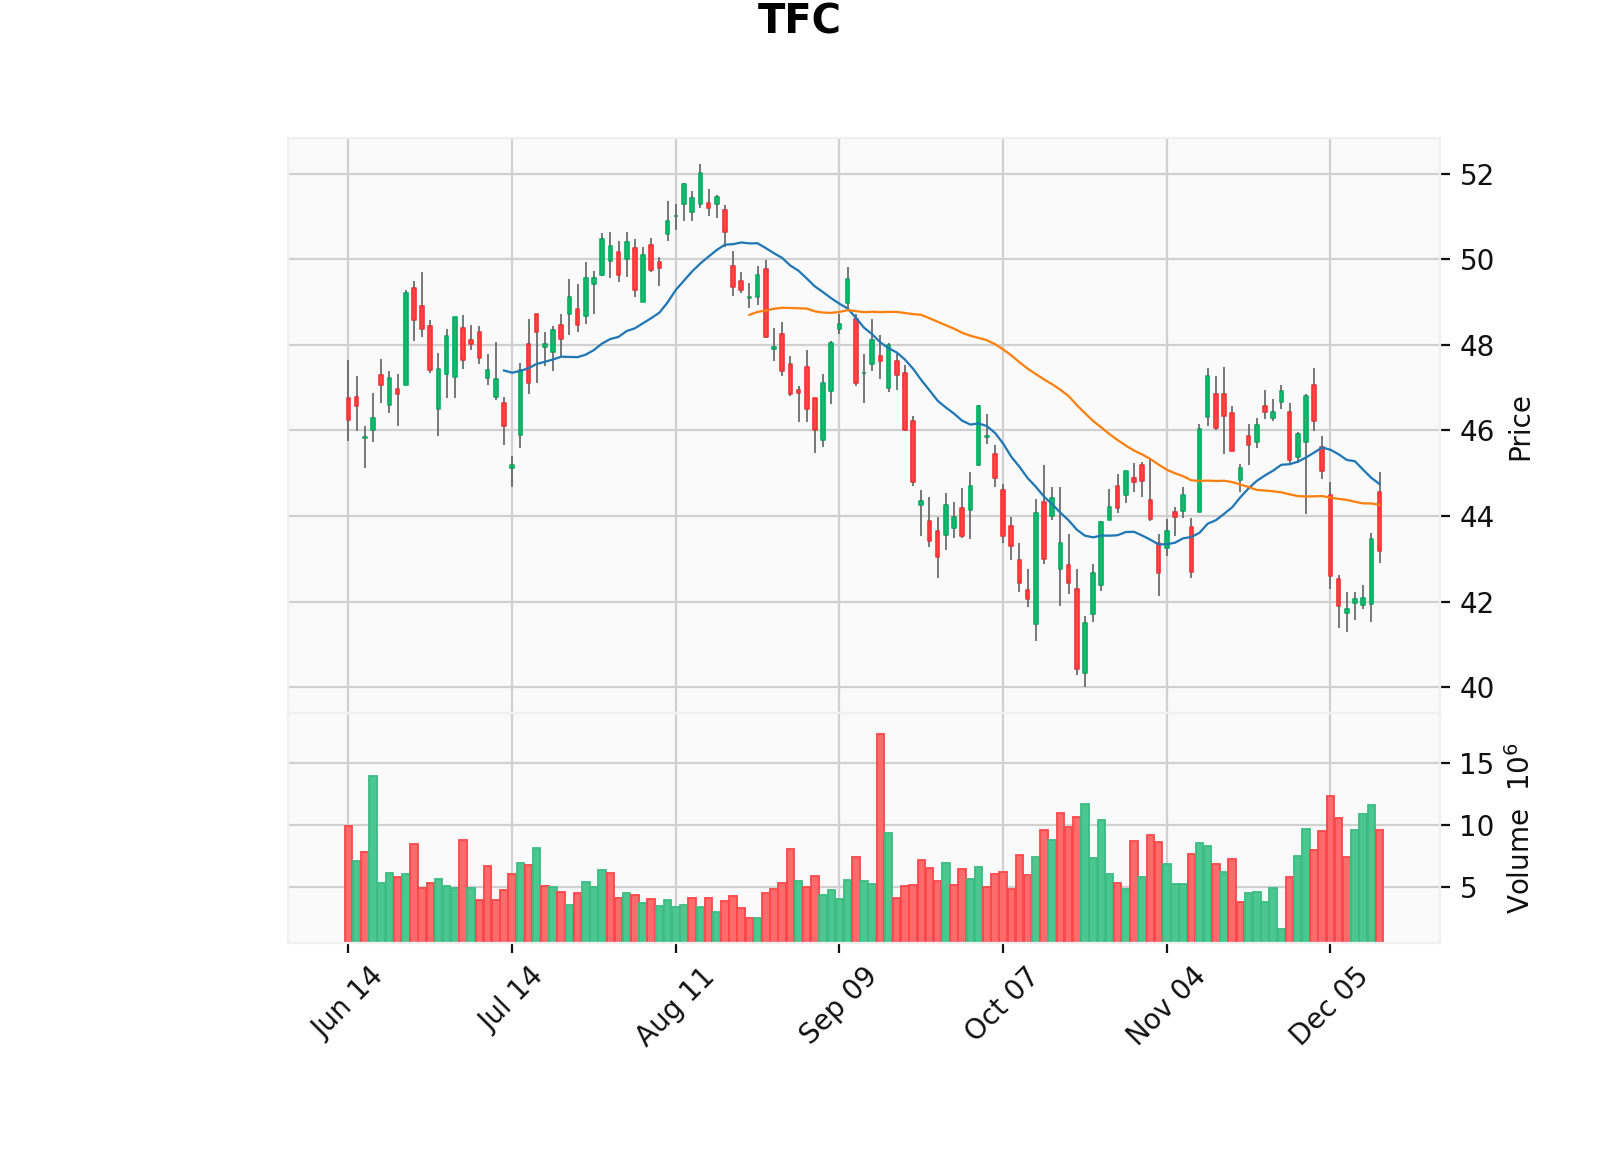

<IPython.core.display.Javascript object>


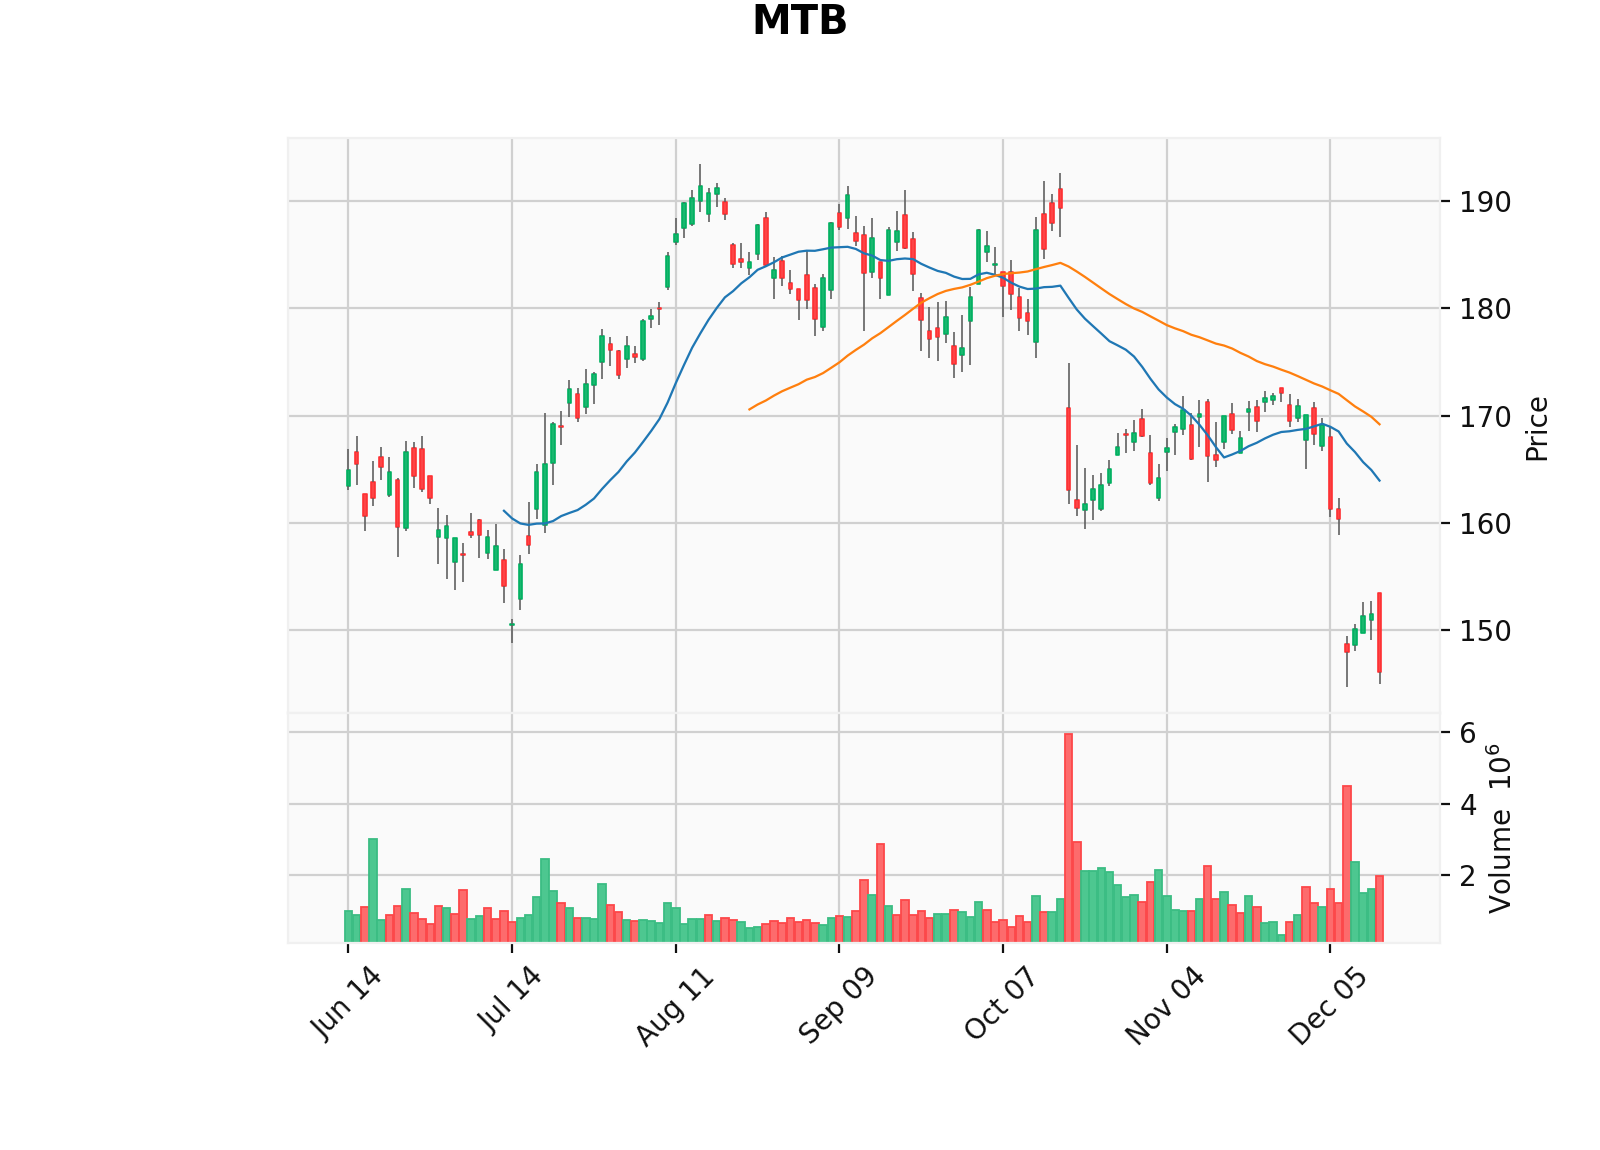

<IPython.core.display.Javascript object>


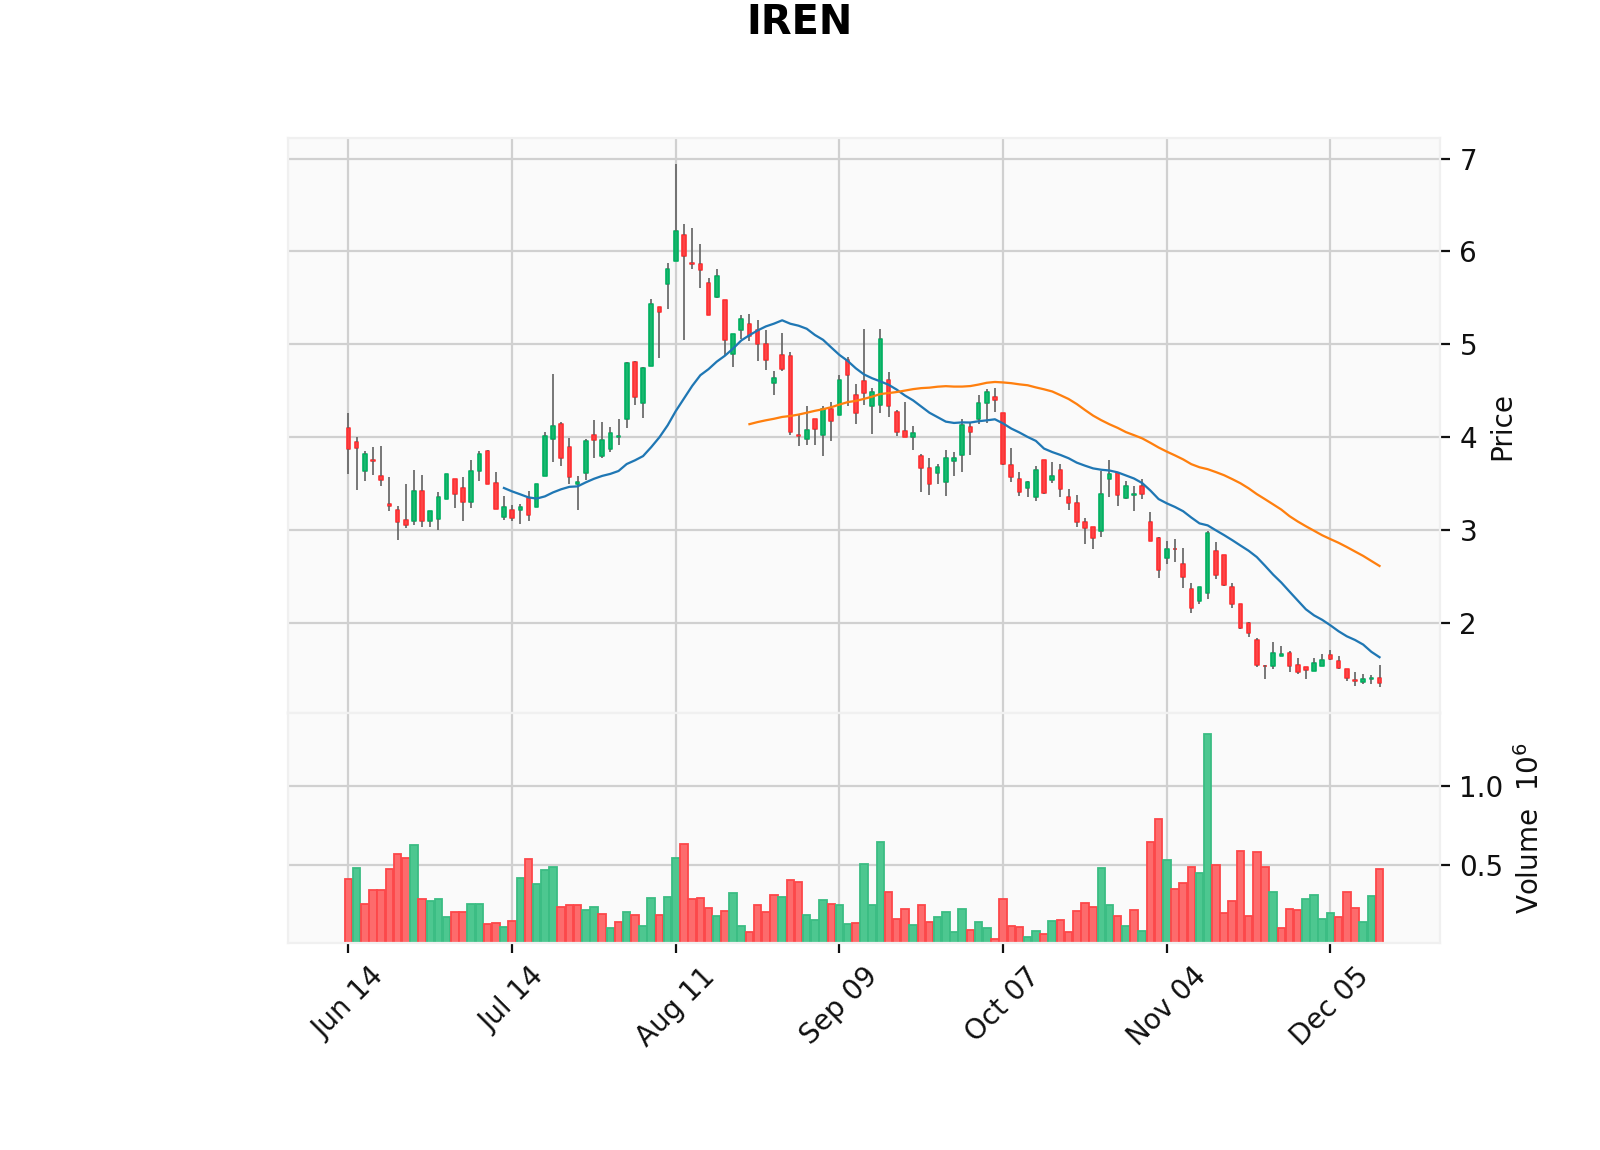

<IPython.core.display.Javascript object>


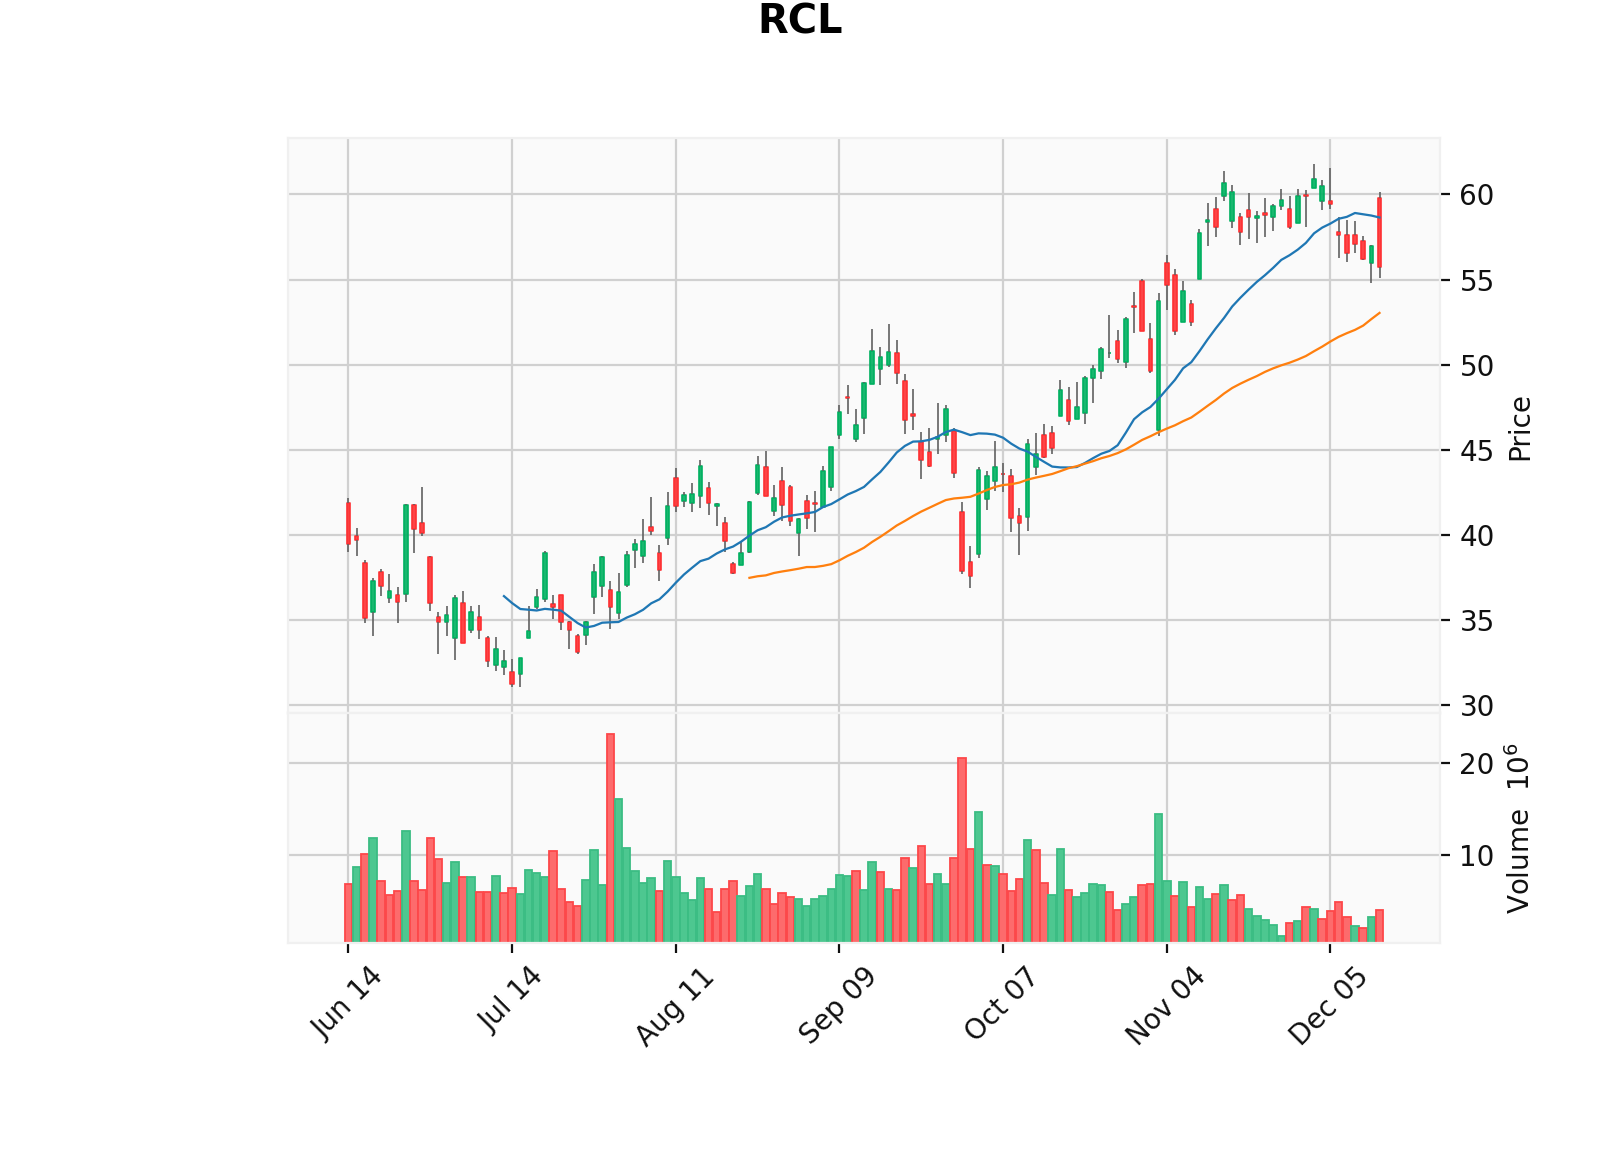

In [92]:
graph_utils = GraphUtils()
graph_utils.draw_graphs(selected_stocks,stocks_data)